In [ ]:
import numpy as np

*compute_loss* computes the error of the parameters w regarding the data x and the labels y. mse = True computes the MSE error and mse = False computes the MAE error.

In [ ]:
def compute_loss(y, tx, w, mse = True):
    N = y.shape[0]
    if mse:
        e = y - tx @ w
        loss = 1/(2 * N) * e.T @ e
    else:
        loss = np.mean(np.abs(y - tx @ w))
    return loss

*mse_gradient* computes the gradient of the MSE loss function regarding the labels y, the data tx and the parameters w

In [ ]:
def mse_gradient(y, tx, w):
    e = y - tx @ w
    grad = -(1/y.shape[0]) * tx.T @ e
    return grad

*mae_gradient* computes the gradient of the MAE loss function regarding the labels y, the data tx and the parameters w

In [ ]:
def mae_gradient(y, tx, w):
    e = y - tx @ w
    e = np.where(e < 0, 1, -1)
    e = np.vstack((e,e)).T * tx
    return np.mean(e, axis = 0)

### least_squares_GD
*least_squares_GD* applies the full gradient descent with respect to the MSE loss function. y are the labels, tx the data, initial_w the initial vector, max_iters are the number of steps of the algorithm and gamma the step size.
at each step, this performs $\underline{w} = \underline{w} - \gamma * \nabla L(\underline{w})$.

In [ ]:
def least_squares_GD(y, tx, initial_w, max_iters, gamma):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    w = initial_w
    for n_iter in range(max_iters):
        grad = mse_grad(y, tx, w)
        w = w - gamma * grad
    loss = compute_loss(y, tx, w)
    return loss, w

### least_squares_SGD
*least_squares_GD* applies batch gradient descent with respect to the MSE loss function. y are the labels, tx the data, initial_w the initial vector, max_iters are the number of steps of the algorithm and gamma the step size.
at each step, this performs $\underline{w}^{(t+1)} = \underline{w}^{(t)} - \gamma * \underline{g}$ where $\underline{g} = \frac{1}{|B|} \sum\limits_{n \in B} \nabla L_n(\underline{w}^{(t)})$

In [ ]:
def least_squares_SGD(y, tx, initial_w, max_iters, gamma, batch_size = 1):
    
    w = initial_w
    rand_list = np.arange(y.shape[0])
    
    for n in np.arange(max_iters):
        np.random.shuffle(rand_list)
        # randomizing y and tx so we can take the first *batch_size* elements
        y = y[rand_list]
        tx = tx[rand_list]
        
        # compute loss and gradent descent
        grad = compute_stoch_gradient(y[:batch_size], tx[:batch_size,:], w)
        
        w = w - gamma * grad
        
    loss = compute_loss(y, tx, w)
    return losse, w

### least square
given tx (N, D+1) and y (N), finds the solution in terms of the lest squares, namely $arg min_{b} || Y - XB ||^2$
which is $B = (X^T X)^{-1} (X^T Y)$

In [ ]:
def least_square_loss(tx, y, w):
    e = y - tx @ w.T
    return (1/y.shape[0]) * e @ e.T

In [ ]:
def least_squares(tx, y):
    XT_X = tx.T @ tx
    XT_Y = tx.T @ y
    w = np.linalg.inv(XT_X) @ XT_Y
    loss = least_square_loss(tx, y, w)
    return w, loss

### ridge regression
given tx (N, D+1), lamdba and y (N), finds the solution in terms of the lest squares, namely $arg min_{b} || Y - XB ||^2 + \lambda ||B||^2$
which is $B = (X^T X + \lambda I_{D+1})^{-1} (X^T Y)$

In [ ]:
def ridge_regression_loss(tx, y, w, lambda_):
    return least_square_loss(tx, y, w) + lambda_ * w.T @ w

In [ ]:
def ridge_regression(tx, y, lambda_):
    XT_X = tx.T @ tx
    XT_Y = tx.T @ y
    w = np.linalg.inv(XT_X + np.eye(tx.shape[1]) * lambda_) @ XT_Y
    loss = ridge_regression_loss(tx, y, w, lambda_)
    return w, loss

In [1]:
import numpy as np
from implementations_clean import *
from proj1_helpers import *

y,X,ids = load_csv_data("train.csv")

X = np.where(X == -999., np.nan, X)
X_ = X

In [ ]:
mass_nan = np.where(np.isnan(X[:,0]), 1, 0) #collumn of DER_mass_MMC with 1s if nan
delta_nan = np.where(np.isnan(X[:,4]), 1, 0) #collumn of DER_deltaeta_jet_jet with 1s if nan
jet_nan = np.where(np.isnan(X[:,-6]), 1, 0) #collumn of PRI_jet_leading_eta with 1s if nan
X = np.column_stack((X, mass_nan, delta_nan, jet_nan))

In [ ]:
col_means = np.nanmedian(X, axis=0)
idxs = np.where(np.isnan(X))
X[idxs] = np.take(col_means, idxs[1])

#feature 1: correlations der_mass_MMC
X_gt_mmc = np.array(X[:,0], copy=True)
X_gt_mmc[X_gt_mmc <= 140] = 140
# X = np.column_stack((X, X_gt_mmc))
X[:,0][X[:,0] > 140] = 140
X = np.column_stack((X, X_gt_mmc))

#feature 2: add momentums
#tau momentum
tau_px = X[:,13]*np.cos(X[:,15])
tau_py = X[:,13]*np.sin(X[:,15])
tau_pz = X[:,13]*np.sinh(X[:,14])
X = np.column_stack((X, tau_px,tau_py,tau_pz))
#lep momentum
lep_px = X[:,16]*np.cos(X[:,18])
lep_py = X[:,16]*np.sin(X[:,18])
lep_pz = X[:,16]*np.sinh(X[:,17])
X = np.column_stack((X, lep_px,lep_py,lep_pz))
#leading jet momentum
jet_px = X[:,23]*np.cos(X[:,25])
jet_py = X[:,23]*np.sin(X[:,25])
jet_pz = X[:,23]*np.sinh(X[:,24])
X = np.column_stack((X, jet_px,jet_py,jet_pz))
#subleading jet momentum
subjet_px = X[:,26]*np.cos(X[:,28])
subjet_py = X[:,26]*np.sin(X[:,28])
subjet_pz = X[:,26]*np.sinh(X[:,27])
X = np.column_stack((X, subjet_px,subjet_py,subjet_pz))
#subleading jet momentum
# DER_met_phi_centrality_cos = np.cos(X[:,11])
# DER_met_phi_centrality_sin = np.sin(X[:,11])
# X = np.column_stack((X, DER_met_phi_centrality_cos,DER_met_phi_centrality_sin))

#feature 3: abs angles
#der_met_phi_centrality
X[:,11] = np.abs(X[:,11])
#tau phi
X[:,15] = np.abs(X[:,15])
#lep phi
X[:,18] = np.abs(X[:,18])
#met phi
X[:,20] = np.abs(X[:,20])
#lead jet phi
X[:,24] = np.abs(X[:,24])
#sublead jet phi
X[:,27] = np.abs(X[:,27])


#feature 4: categorical PRI_jet_num
jet_num_0 = (X[:,22] == 0).astype(int)
jet_num_1 = (X[:,22] == 1).astype(int)
jet_num_2 = (X[:,22] == 2).astype(int)
jet_num_3 = (X[:,22] == 3).astype(int)

# #feature 5: pt ratios
# #tau_lep_ratio = PRI_tau_pt/PRI_lep_pt
# tau_lep_ratio = X[:,13]/X[:,16]
tau_lep_ratio = X[:,13]/X[:,16]
# #jets_ratio = PRI_jet_leading_pt/PRI_jet_subleading_pt
# jets_ratio = X[:,22]/X[:,25]
# jets_ratio = X[:,23]/X[:,25]
# #met_tot_ratio = PRI_met/PRI_met_sumet
met_tot_ratio = X[:,19]/X[:,21]
# X = np.column_stack((X, tau_lep_ratio,jets_ratio,met_tot_ratio))
X = np.column_stack((X, tau_lep_ratio,met_tot_ratio))

# #feature 6: jets_diff_angle
jets_diff_angle = np.cos(X[:,24]-X[:,27])
X = np.column_stack((X, jets_diff_angle))

#TEST EXTRA COS/SIN ANGLES

# df = pd.DataFrame(X)
# df.head()
# print(X[:,22] == 1).astype(int)

In [8]:
def make_features(X):
    # converting -999. to nan to use np.nanmean and np.nanstd
    X = np.where(X == -999., np.nan, X)
    # standardizing the data Xd = (X_d - E[X_d])/(std(X_d))
    X, means, stds = standardize(X)
    # since data is standirdized, the mean is more or less 0 for each feature so replacing by zero is reasonable and helps computations
    X = np.where(np.isnan(X), 0, X)
    # adding the 1 padding
    return np.column_stack((np.ones(X.shape[0]), X))

In [15]:
import pandas as pd
data = pd.read_csv('train.csv')

In [16]:
data = data.replace(-999.000, np.nan)
N = data['Id'].shape[0]
data.isnull().sum(axis = 0) / N

Id                             0.000000
Prediction                     0.000000
DER_mass_MMC                   0.152456
DER_mass_transverse_met_lep    0.000000
DER_mass_vis                   0.000000
DER_pt_h                       0.000000
DER_deltaeta_jet_jet           0.709828
DER_mass_jet_jet               0.709828
DER_prodeta_jet_jet            0.709828
DER_deltar_tau_lep             0.000000
DER_pt_tot                     0.000000
DER_sum_pt                     0.000000
DER_pt_ratio_lep_tau           0.000000
DER_met_phi_centrality         0.000000
DER_lep_eta_centrality         0.709828
PRI_tau_pt                     0.000000
PRI_tau_eta                    0.000000
PRI_tau_phi                    0.000000
PRI_lep_pt                     0.000000
PRI_lep_eta                    0.000000
PRI_lep_phi                    0.000000
PRI_met                        0.000000
PRI_met_phi                    0.000000
PRI_met_sumet                  0.000000
PRI_jet_num                    0.000000


In [2]:
mass_nan_index = 0
jet_nan_indexes = [4,5,6,12,26,27,28]
jet_sub_nan_indexes = [23,24,25]

## removing all others problematic columns with nans
X_mass = np.delete(X_,[4,5,6,12,23,24,25,26,27,28] ,1)

defined_mass_idx = np.where(np.isfinite(X_mass[:,0])) #indexes of samples with a mass
undefined_mass_idx = np.where(np.isnan(X_mass[:,0]))  #indexes of samples with a missing mass

defined_mass_samples = X_mass[defined_mass_idx][:,1:]   ## data with defined mass
defined_masses = X_mass[defined_mass_idx][:,1] # masses
undefined_mass_samples = X_mass[undefined_mass_idx][:,1:] ## data with undefined mass

weighted_sum = []
for undef in undefined_mass_samples:
    a = np.sum(np.abs(defined_mass_samples @ undef * defined_masses))
    b = np.sum(np.abs(defined_mass_samples @ undef))
    weighted_sum.append(a/b)
    
masses = np.zeros(X_.shape[0])
masses[defined_mass_idx] = defined_masses
masses[undefined_mass_idx] = weighted_sum

X_[:,0] = masses

In [43]:
pd.DataFrame(X_).head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,51.655000,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,...,-0.277,258.733,2.0,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,68.768000,68.768,103.235,48.146,NaN,NaN,NaN,3.473,2.078,125.157,...,-1.916,164.546,1.0,46.226,0.725,1.158,NaN,NaN,NaN,46.226
2,41.633364,162.172,125.953,35.635,NaN,NaN,NaN,3.148,9.336,197.814,...,-2.186,260.414,1.0,44.251,2.053,-2.028,NaN,NaN,NaN,44.251
3,81.417000,81.417,80.943,0.414,NaN,NaN,NaN,3.310,0.414,75.968,...,0.060,86.062,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000
4,16.915000,16.915,134.805,16.405,NaN,NaN,NaN,3.891,16.405,57.983,...,-0.871,53.131,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000


In [55]:
A = make_features(X_)[:,1:]
nans = [4,5,6,12,23,24,25,26,27,28]
for i in nans:
    A[:, i] = np.zeros(A.shape[0])

#A = np.delete(A,[4,5,6,12,23,24,25,26,27,28], 1)
y_norm = np.where(y == 0, -1, 1)
y_norm = (y_norm - np.mean(y_norm)) / np.std(y_norm)

In [56]:
pd.DataFrame(A).head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.340712,0.068332,0.407680,-0.469966,0.0,0.0,0.0,0.882478,1.033099,0.339894,...,-0.147267,0.386847,1.044402,0.0,0.0,0.0,0.0,0.0,0.0,0.412510
1,0.943682,0.552505,0.540136,-0.153167,0.0,0.0,0.0,1.404888,-0.756027,-0.287584,...,-1.051683,-0.357719,0.021305,0.0,0.0,0.0,0.0,0.0,0.0,-0.273820
2,-0.012396,3.195156,1.096560,-0.349710,0.0,0.0,0.0,0.989770,-0.430168,0.340361,...,-1.200672,0.400135,0.021305,0.0,0.0,0.0,0.0,0.0,0.0,-0.293970
3,1.389365,0.910379,-0.005853,-0.903016,0.0,0.0,0.0,1.196690,-0.830735,-0.712705,...,0.038692,-0.978149,-1.001792,0.0,0.0,0.0,0.0,0.0,0.0,-0.745439
4,-0.883338,-0.914556,1.313369,-0.651804,0.0,0.0,0.0,1.938794,-0.112795,-0.868143,...,-0.475042,-1.238475,-1.001792,0.0,0.0,0.0,0.0,0.0,0.0,-0.745439


In [81]:
X_1 = standardize(A)
X_2,_,_ = standardize(A**2)
X_3,_,_ = standardize(A**3)
non_zero_X = np.where(A == 0, np.nan, A.T)
inv = 1/non_zero_X
inv,_,_ = standardize(inv)

In [75]:
N = y.shape[0]
C1 = X_1.T @ y_norm / N
C2 = X_2.T @ y_norm / N
C3 = X_3.T @ y_norm / N
C4 = inv.T @ y_norm / N

<StemContainer object of 3 artists>

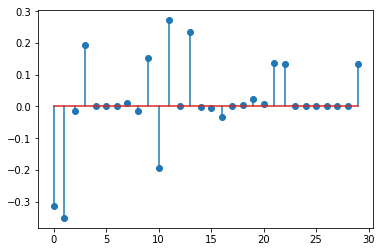

In [76]:
import matplotlib.pyplot as plt
t = np.arange(len(C1))
plt.stem(t, C1) # X

<StemContainer object of 3 artists>

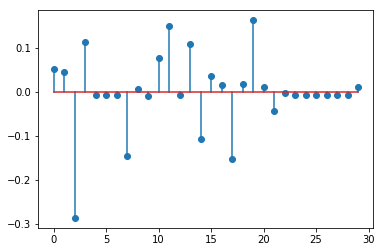

In [77]:
plt.stem(t, C2) 

<StemContainer object of 3 artists>

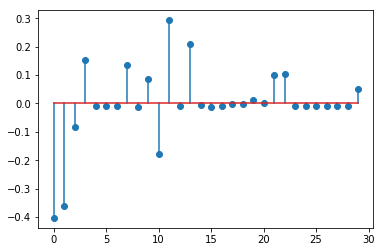

In [78]:
plt.stem(t, C3) # X**3

In [79]:
# DER_MET_PHI_centrality at cubic seems strong

<StemContainer object of 3 artists>

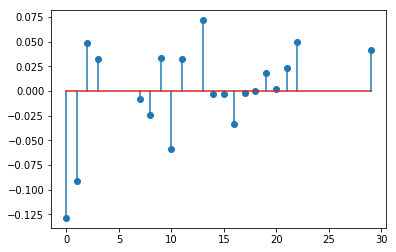

In [80]:
plt.stem(t, C4) # 1/X

In [64]:
# PRI_jet_num at inverse seems important

In [65]:
pd.DataFrame(A).head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.340712,0.068332,0.407680,-0.469966,0.0,0.0,0.0,0.882478,1.033099,0.339894,...,-0.147267,0.386847,1.044402,0.0,0.0,0.0,0.0,0.0,0.0,0.412510
1,0.943682,0.552505,0.540136,-0.153167,0.0,0.0,0.0,1.404888,-0.756027,-0.287584,...,-1.051683,-0.357719,0.021305,0.0,0.0,0.0,0.0,0.0,0.0,-0.273820
2,-0.012396,3.195156,1.096560,-0.349710,0.0,0.0,0.0,0.989770,-0.430168,0.340361,...,-1.200672,0.400135,0.021305,0.0,0.0,0.0,0.0,0.0,0.0,-0.293970
3,1.389365,0.910379,-0.005853,-0.903016,0.0,0.0,0.0,1.196690,-0.830735,-0.712705,...,0.038692,-0.978149,-1.001792,0.0,0.0,0.0,0.0,0.0,0.0,-0.745439
4,-0.883338,-0.914556,1.313369,-0.651804,0.0,0.0,0.0,1.938794,-0.112795,-0.868143,...,-0.475042,-1.238475,-1.001792,0.0,0.0,0.0,0.0,0.0,0.0,-0.745439


In [154]:
temp = np.ones((A.shape[0], int(A.shape[1] * (A.shape[1] + 1) / 2)))
k = 0
for i in range(A.shape[1]):
    for j in range(i+1):
        temp[:,k] = A[:,i] * A[:,j]
        k+=1

In [155]:
pd.DataFrame(temp).head()

,0,1,2,3,4,5,6,7,8,9,...,455,456,457,458,459,460,461,462,463,464
0,0.116085,0.023282,0.004669,0.138902,0.027858,0.166203,-0.160123,-0.032114,-0.191596,0.220868,...,-0.060749,0.159578,0.430827,0.0,0.0,0.0,0.0,0.0,0.0,0.170165
1,0.890536,0.521389,0.305262,0.509717,0.298428,0.291747,-0.144541,-0.084626,-0.082731,0.023460,...,0.287972,0.097951,-0.005834,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.074977
2,0.000154,-0.039608,10.209019,-0.013593,3.503680,1.202444,0.004335,-1.117377,-0.383478,0.122297,...,0.352961,-0.117628,-0.006263,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.086418
3,1.930335,1.264849,0.828790,-0.008132,-0.005329,0.000034,-1.254618,-0.822087,0.005286,0.815437,...,-0.028843,0.729151,0.746775,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.555680
4,0.780286,0.807862,0.836413,-1.160149,-1.201150,1.724937,0.575764,0.596112,-0.856059,0.424849,...,0.354115,0.923208,0.746775,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.555680


In [156]:
temp,_,_ = standardize(temp)

In [159]:
correlations = temp.T @ y_norm / N

<StemContainer object of 3 artists>

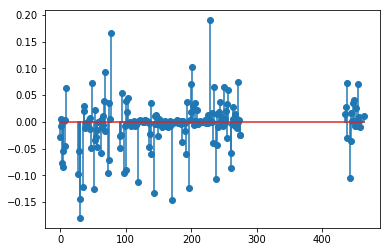

In [160]:
plt.stem(correlations) # correlations of multiplication of features

#### idea: what if we used least squares to fit the nan?

In [47]:
import pandas as pd
mass_nan_index = [0]
jet_nan_indexes = [4,5,6,12,26,27,28]
jet_sub_nan_indexes = [23,24,25]
X_noNans = np.delete(X_, np.concatenate((jet_nan_indexes, jet_sub_nan_indexes)), 1)

In [29]:
defined_mass_idx = np.where(np.isfinite(X_noNans[:,0])) #indexes of samples with a mass
undefined_mass_idx = np.where(np.isnan(X_noNans[:,0]))  #indexes of samples with a missing mass

X_mass = X_noNans[defined_mass_idx][:,1:]
y_mass = X_noNans[defined_mass_idx][:,:1]

X_mass,_,_ = standardize(X_mass)
y_mass,_,_ = standardize(y_mass)

In [51]:
w, loss = ridge_regression(X_mass, y_mass, 0.01)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 19)

In [48]:
values,_,_ = standardize(X_noNans[undefined_mass_idx][:,1:])
pd.DataFrame(values @ w)

,0
0,22.882747
1,2.183337
2,-3.592283
3,-0.778398
4,-3.431592
5,-5.094166
6,0.132156
7,-0.058166
8,4.483178
9,-2.849010


In [45]:
y_mass

array([[ 0.28991353],
       [ 0.68202131],
       [ 0.38476846],
       ...,
       [ 1.66081601],
       [-0.28624947],
       [-0.46960659]])